In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import re


In [7]:
import csv
import logging
from typing import Dict, List, Tuple

import numpy as np
import pytrec_eval

def evaluate(
    qrels: Dict[str, Dict[str, int]],
    results: Dict[str, Dict[str, float]],
    k_values: List[int],
) -> Tuple[Dict[str, float], Dict[str, float], Dict[str, float], Dict[str, float]]:
    """
    仿照 beir.retrieval.evaluation.EvaluateRetrieval.evaluate 编写的评估函数。
    """
    ndcg = {}
    _map = {}
    recall = {}
    precision = {}

    for k in k_values:
        ndcg[f"NDCG@{k}"] = 0.0
        _map[f"MAP@{k}"] = 0.0
        recall[f"Recall@{k}"] = 0.0
        precision[f"P@{k}"] = 0.0

    map_string = "map_cut." + ",".join([str(k) for k in k_values])
    ndcg_string = "ndcg_cut." + ",".join([str(k) for k in k_values])
    recall_string = "recall." + ",".join([str(k) for k in k_values])
    precision_string = "P." + ",".join([str(k) for k in k_values])
    evaluator = pytrec_eval.RelevanceEvaluator(
        qrels, {map_string, ndcg_string, recall_string, precision_string}
    )
    scores = evaluator.evaluate(results)

    for query_id in scores.keys():
        for k in k_values:
            ndcg[f"NDCG@{k}"] += scores[query_id]["ndcg_cut_" + str(k)]
            _map[f"MAP@{k}"] += scores[query_id]["map_cut_" + str(k)]
            recall[f"Recall@{k}"] += scores[query_id]["recall_" + str(k)]
            precision[f"P@{k}"] += scores[query_id]["P_" + str(k)]

    for k in k_values:
        ndcg[f"NDCG@{k}"] = round(ndcg[f"NDCG@{k}"] / len(scores), 5)
        _map[f"MAP@{k}"] = round(_map[f"MAP@{k}"] / len(scores), 5)
        recall[f"Recall@{k}"] = round(recall[f"Recall@{k}"] / len(scores), 5)
        precision[f"P@{k}"] = round(precision[f"P@{k}"] / len(scores), 5)

    # for eval_metric in [ndcg, _map, recall, precision]:
    #     logging.info("\n")
    #     for k, v in eval_metric.items():
    #         logging.info(f"{k}: {v:.4f}")

    return recall


def load_gt(gt_path: str) -> Dict[str, Dict[str, int]]:
    """
    加载 ground-truth npy 文件并转换为 pytrec_eval 所需的 qrels 格式。
    查询ID将使用其在npy文件中的索引（0, 1, 2, ...）。
    """
    gt_data = np.load(gt_path, allow_pickle=True)
    gt_data = gt_data.reshape(-1, 1)
    # gt_data = gt_data[:1000]
    qrels = {}
    for i, gt_list in enumerate(gt_data):
        query_id = str(i)
        qrels[query_id] = {}
        for passage_id in gt_list:
            qrels[query_id][str(passage_id)] = 1  # 假设相关性得分为1
    return qrels


def load_results(results_path: str) -> Dict[str, Dict[str, float]]:
    """
    加载检索结果的tsv文件并转换为 pytrec_eval 所需的 results 格式。
    - 如果文件有4列 (query_id, passage_id, rank, score)，则使用第四列的分数。
    - 如果文件只有3列 (query_id, passage_id, rank)，则使用 1/rank 作为分数。
    """
    results = {}
    with open(results_path, "r", encoding="utf-8") as f:
        reader = csv.reader(f, delimiter="\t")
        for row in reader:
            if not row: continue # Skip empty lines

            query_id, passage_id = row[0], row[1]
            
            if query_id not in results:
                results[query_id] = {}
            
            # 判断使用真实分数还是生成代理分数
            if len(row) == 4:
                score = float(row[3])
            elif len(row) == 3:
                rank = int(row[2])
                score = 1.0 / rank
            else:
                logging.warning(f"Skipping malformed line with {len(row)} columns: {row}")
                continue
            
            results[query_id][passage_id] = score
            
    return results

In [8]:
import os

# Base directory
base_dir = "/data/lijunlin/sigmod2025-results/answer"

# Dataset keyword to filter by (e.g., "clip", "clerc", "multiqa_med")
dataset_keyword = "clip-multi-clustering-IGP"

# Collect full paths for matching files
matching_paths = [
    os.path.join(base_dir, f)
    for f in os.listdir(base_dir)
    if f.startswith(dataset_keyword + "-") and f.endswith(".tsv")
]

# Print results
if matching_paths:
    print(f"Found {len(matching_paths)} files for dataset '{dataset_keyword}':\n")
    for path in sorted(matching_paths):
        print(path)
else:
    print(f"No files found for dataset '{dataset_keyword}'.")


FileNotFoundError: [Errno 2] No such file or directory: '/data/lijunlin/sigmod2025-results/answer'

In [8]:
import os
import logging

# --- Logging setup ---
logging.basicConfig(
    format="%(asctime)s - %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
)

# --- Ground-truth file ---
GT_FILE_PATH = "/home/ali/hnswlib/evaluation/clerc_gt.npy"

# --- Base results folder ---
BASE_RESULTS_DIR = "/data/lijunlin/sigmod2025-results/answer"

# --- Dataset filter ---
DATASET_KEYWORD = "clip-multi-clustering-IGP"  # Change to e.g. "clerc", "multiqa_med", etc.

# --- Evaluation parameters ---
K_VALUES = [10]

# --- Your existing functions (assumed imported) ---
# from your_module import load_gt, load_results, evaluate

# --- Step 1: Collect all matching result files ---
result_paths = [
    os.path.join(BASE_RESULTS_DIR, f)
    for f in os.listdir(BASE_RESULTS_DIR)
    if f.startswith(DATASET_KEYWORD + "-") and f.endswith(".tsv")
]

if not result_paths:
    logging.warning(f"No result files found for dataset '{DATASET_KEYWORD}'.")
    exit()

# --- Step 2: Load GT once ---
logging.info(f"Loading ground-truth file {GT_FILE_PATH}...")
qrels_data = load_gt(GT_FILE_PATH)

# --- Step 3: Iterate over all result files ---
for path in sorted(result_paths):
    logging.info(f"Evaluating results file: {path} ...")
    try:
        results_data = load_results(path)
        evaluate(qrels=qrels_data, results=results_data, k_values=K_VALUES)
        logging.info(f"✅ Finished evaluating {os.path.basename(path)}")
    except Exception as e:
        logging.error(f"❌ Failed to evaluate {path}: {e}")

logging.info("🎯 All evaluations completed.")


2025-10-17 15:41:18 - Loading ground-truth file /home/ali/hnswlib/evaluation/clerc_gt.npy...
2025-10-17 15:41:18 - Evaluating results file: /data/lijunlin/sigmod2025-results/answer/clip-multi-clustering-IGP-top10-n_centroid_1024-n_bit_2-nprobe_32-probe_topk_1000.tsv ...
2025-10-17 15:41:18 - ✅ Finished evaluating clip-multi-clustering-IGP-top10-n_centroid_1024-n_bit_2-nprobe_32-probe_topk_1000.tsv
2025-10-17 15:41:18 - Evaluating results file: /data/lijunlin/sigmod2025-results/answer/clip-multi-clustering-IGP-top10-n_centroid_16384-n_bit_2-nprobe_256-probe_topk_1000.tsv ...
2025-10-17 15:41:19 - ✅ Finished evaluating clip-multi-clustering-IGP-top10-n_centroid_16384-n_bit_2-nprobe_256-probe_topk_1000.tsv
2025-10-17 15:41:19 - Evaluating results file: /data/lijunlin/sigmod2025-results/answer/clip-multi-clustering-IGP-top10-n_centroid_16384-n_bit_2-nprobe_256-probe_topk_10000.tsv ...
2025-10-17 15:41:19 - ✅ Finished evaluating clip-multi-clustering-IGP-top10-n_centroid_16384-n_bit_2-nprob

In [9]:
algorithms = ["IGP", "Dessert", "Plaid", "MUVERA", "Multi-HNSW", "HNSW-D", "C-Multi-HNSW"]
datasets = ["CLERC-128", "CLERC-384", "CLERC-768", "CLERC-1024"]

In [34]:
import os
import re
import pandas as pd

# REQUIRED: you should already have these defined in your notebook
# - qrels_data  (from your load_gt)
# - K_VALUES    (e.g., [10])
# - evaluate(qrels, results, k_values) -> dict of metrics (e.g., {'Recall@10': 0.736})

# ----------------------------
# Config
# ----------------------------
directory = "/data/lijunlin/sigmod2025-results/multi-hnsw-result"
# keyword = "clip-multi-clustering"
# keyword = "clip-multi-clustering_HNSW"
# keyword = "clef_med_HNSW"
# keyword = "clerc_small_HNSW"
# keyword = "clerc_HNSW"
keyword = "clerc_large_HNSW"

# ----------------------------
# File pairing
# ----------------------------
all_files = os.listdir(directory)
txt_files = [
    f for f in all_files
    if f.endswith(".txt") and keyword in f and "metadata" not in f
]

file_pairs = {}
for f in txt_files:
    if f.endswith("_summary.txt"):
        base_name = f[:-len("_summary.txt")]
        file_pairs.setdefault(base_name, {})["summary"] = os.path.join(directory, f)
    else:
        base_name = f[:-len(".txt")]
        file_pairs.setdefault(base_name, {})["results"] = os.path.join(directory, f)

# ----------------------------
# Helpers
# ----------------------------
def load_results_tsv(path: str) -> pd.DataFrame:
    # Results: query_id, passage_id, rank, score (tab-separated, no header)
    return pd.read_csv(
        path,
        sep="\t",
        header=None,
        names=["query_id", "passage_id", "rank", "score"],
        dtype={"query_id": int, "passage_id": int, "rank": int, "score": float}
    )

def extract_avg_retrieval_time(summary_text: str) -> float | None:
    # Robust parser for avg retrieval time (ms)
    patterns = [
        r"Average\s+Query\s+Time:\s*([\d.]+)\s*ms",
        r"Avg\s*retrieval\s*time\s*[:=]\s*([\d.]+)\s*ms",
        r"retrieval_time_single_query_average\(ms\)\s*[:=]\s*([\d.]+)",
        r"avg.*?ms\s*[:=]\s*([\d.]+)",
    ]
    for pat in patterns:
        m = re.search(pat, summary_text, flags=re.IGNORECASE)
        if m:
            try:
                return float(m.group(1))
            except ValueError:
                pass
    return None

def df_results_to_dict(df_res: pd.DataFrame) -> dict:
    # Drop duplicates (query, passage) keeping highest score; cast IDs to str
    df = (
        df_res.sort_values('score', ascending=False)
              .drop_duplicates(['query_id', 'passage_id'])
              .astype({'query_id': str, 'passage_id': str})
    )
    return (
        df.groupby('query_id')
          .apply(lambda g: dict(zip(g['passage_id'], g['score'])))
          .to_dict()
    )

# ----------------------------
# Build final DataFrame: one row per base with qps + metrics
# ----------------------------
rows = []
for base, pair in file_pairs.items():
    # Summary → avg_ms → qps
    avg_ms = None
    if 'summary' in pair and pair['summary']:
        with open(pair['summary'], 'r', encoding='utf-8', errors='ignore') as f:
            avg_ms = extract_avg_retrieval_time(f.read())
    qps = (1000.0 / avg_ms) if (avg_ms is not None and avg_ms > 0) else None

    # Results → metrics via evaluate
    metrics = {}
    if 'results' in pair and pair['results']:
        df_res = load_results_tsv(pair['results'])
        results_dict = df_results_to_dict(df_res)
        metrics = evaluate(qrels=qrels_data, results=results_dict, k_values=K_VALUES) or {}

    row = {'Algorithm': algorithms[4], 'QPS': qps, "Dataset": datasets[2], "Recall": metrics["Recall@10"]}
    # row.update(metrics)  # adds e.g. 'Recall@10', etc.
    rows.append(row)

mvrhnsw_df = pd.DataFrame(rows).reset_index(drop=True)
mvrhnsw_df

/tmp/ipykernel_3491789/3426279967.py:78: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: dict(zip(g['passage_id'], g['score'])))
/tmp/ipykernel_3491789/3426279967.py:78: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: dict(zip(g['passage_id'], g['score'])))
/tmp/ipykernel_3491789/3426279967.py:78: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is de

,Algorithm,QPS,Dataset,Recall
0,MVR-HNSW,1.056848,CLERC-1024,0.183
1,MVR-HNSW,1.333156,CLERC-1024,0.158
2,MVR-HNSW,1.294716,CLERC-1024,0.157
3,MVR-HNSW,1.754940,CLERC-1024,0.085
4,MVR-HNSW,0.532422,CLERC-1024,0.251
5,MVR-HNSW,0.526837,CLERC-1024,0.260
6,MVR-HNSW,1.053719,CLERC-1024,0.180


In [35]:
def extract_limit(row):
    identifier = row['Identifier']
    name = row['Algorithm']
    
    # Default to None
    match = None

    if name == "IGP":
        # Extract probe_topk
        match = re.search(r'probe_topk_(\d+)', identifier)
    
    if match:
        return int(match.group(1))
    else:
        return 0  # If pattern not found, assume safe to keep


In [36]:
# --- Configuration ---
JSON_ROOT_DIR = "/data/lijunlin/sigmod2025-results/performance"
TSV_ROOT_DIR = "/data/lijunlin/sigmod2025-results/answer/"
KEYWORD_JSON = "clip-multi-clustering-retrieval-IGP"
KEYWORD_TSV = "clip-multi-clustering-IGP"

# --- Find files with keyword ---
def find_files_with_keyword(root_dir, keyword, ext):
    matched_files = []
    for dirpath, _, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith(ext) and keyword in filename:
                matched_files.append(os.path.join(dirpath, filename))
    return matched_files

# --- Load JSON file safely ---
def load_json_file(filepath):
    try:
        with open(filepath, "r") as f:
            return json.load(f)
    except Exception as e:
        logging.error(f"Failed to read {filepath}: {e}")
        return None

# --- Extract identifier from filename ---
def get_identifier(filename, keyword):
    base = os.path.basename(filename)
    return base.replace(keyword, "").replace(".json", "").replace(".tsv", "")

# --- Pair JSON and TSV files by shared identifier ---
def pair_json_tsv(json_files, tsv_files, keyword_json, keyword_tsv):
    json_map = {get_identifier(f, keyword_json): f for f in json_files}
    tsv_map = {get_identifier(f, keyword_tsv): f for f in tsv_files}

    pairs = []
    for identifier, json_path in json_map.items():
        if identifier in tsv_map:
            pairs.append((identifier, json_path, tsv_map[identifier]))
    return pairs

In [44]:
# --- Define multiple keyword pairs with names ---

import json
keyword_pairs = [
    # ("clerc_small-retrieval-IGP", "clerc_small-IGP", "IGP"),
    # ("clerc_small-retrieval-dessert", "clerc_small-dessert", "Dessert"),
    # ("clerc_small-retrieval-plaid", "clerc_small-plaid", "Plaid"),

    # ("clerc-retrieval-dessert", "clerc-dessert",  "Dessert"),
    # ("clerc-retrieval-plaid","clerc-plaid",  "Plaid"),
    # ("clerc-retrieval-IGP", "clerc-IGP", "IGP"),

    ("clerc_large-retrieval-dessert", "clerc_large-dessert",  "Dessert"),
    ("clerc_large-retrieval-plaid","clerc_large-plaid",  "Plaid"),
    ("clerc_large-retrieval-IGP", "clerc_large-IGP", "IGP"),
    
    
]

all_results = []

for KEYWORD_JSON, KEYWORD_TSV, name in keyword_pairs:

    logging.info(f"Processing keyword pair: JSON='{KEYWORD_JSON}', TSV='{KEYWORD_TSV}' (Name='{name}')")
    
    # Find files
    json_files = find_files_with_keyword(JSON_ROOT_DIR, KEYWORD_JSON, ".json")
    tsv_files = [
        os.path.join(TSV_ROOT_DIR, f)
        for f in os.listdir(TSV_ROOT_DIR)
        if f.startswith(KEYWORD_TSV + "-") and f.endswith(".tsv")
    ]

    # Pair files by identifier
    pairs = pair_json_tsv(json_files, tsv_files, KEYWORD_JSON, KEYWORD_TSV)

    # Process each pair
    for identifier, json_file, tsv_file in pairs:
        logging.info(f"Processing pair: {identifier}")

        data = load_json_file(json_file)
        if data is None:
            continue
        
        if name == 'IGP':
            avg_ms = float(data['search_time']['retrieval_time_single_query_average(ms)'])
        else:
            avg_ms = float(data['search_time']['average_query_time_ms'])
        qps = 1000 / avg_ms

        results_data = load_results(tsv_file)
        recall = evaluate(qrels=qrels_data, results=results_data, k_values=K_VALUES)

        all_results.append({
            "Identifier":identifier,
            'Recall': recall['Recall@10'],
            'QPS': qps,
            'Algorithm': name,  # <-- Add name here
            "Dataset": datasets[2]
        })

# Convert to DataFrame
df_all_results = pd.DataFrame(all_results)

df_all_results['limit_value'] = df_all_results.apply(extract_limit, axis=1)

# Filter rows where limit_value <= 10000
df_filtered = df_all_results[df_all_results['limit_value'] <= 100000]


# Drop the temporary column
df_filtered.drop(columns=['limit_value'], inplace=True)
df_filtered = df_all_results.copy()


df_sorted = df_filtered.groupby("Algorithm", group_keys=False).apply(
    lambda x: x.sort_values(by="Recall", ascending=True)
)

df_filtered =df_sorted

2025-10-18 00:16:07 - Processing keyword pair: JSON='clerc_large-retrieval-dessert', TSV='clerc_large-dessert' (Name='Dessert')
2025-10-18 00:16:07 - Processing pair: -top10-n_table_64-initial_filter_k_500-nprobe_query_2-remove_centroid_dupes_True-n_thread_1
2025-10-18 00:16:07 - Processing pair: -top10-n_table_64-initial_filter_k_1000-nprobe_query_4-remove_centroid_dupes_True-n_thread_1
2025-10-18 00:16:08 - Processing pair: -top10-n_table_64-initial_filter_k_100-nprobe_query_4-remove_centroid_dupes_True-n_thread_1
2025-10-18 00:16:08 - Processing pair: -top10-n_table_64-initial_filter_k_10-nprobe_query_4-remove_centroid_dupes_True-n_thread_1
2025-10-18 00:16:08 - Processing pair: -top10-n_table_64-initial_filter_k_1000-nprobe_query_2-remove_centroid_dupes_True-n_thread_1
2025-10-18 00:16:08 - Processing pair: -top10-n_table_64-initial_filter_k_50-nprobe_query_2-remove_centroid_dupes_True-n_thread_1
2025-10-18 00:16:09 - Processing pair: -top10-n_table_64-initial_filter_k_10-nprobe_qu

In [45]:
df_sorted

,Identifier,Recall,QPS,Algorithm,Dataset,limit_value
3,-top10-n_table_64-initial_filter_k_10-nprobe_q...,0.000,53.242398,Dessert,CLERC-1024,0
2,-top10-n_table_64-initial_filter_k_100-nprobe_...,0.000,45.526050,Dessert,CLERC-1024,0
6,-top10-n_table_64-initial_filter_k_10-nprobe_q...,0.000,67.033353,Dessert,CLERC-1024,0
7,-top10-n_table_64-initial_filter_k_500-nprobe_...,0.000,27.989122,Dessert,CLERC-1024,0
9,-top10-n_table_64-initial_filter_k_50-nprobe_q...,0.000,49.628322,Dessert,CLERC-1024,0
0,-top10-n_table_64-initial_filter_k_500-nprobe_...,0.001,32.079045,Dessert,CLERC-1024,0
5,-top10-n_table_64-initial_filter_k_50-nprobe_q...,0.001,61.422592,Dessert,CLERC-1024,0
1,-top10-n_table_64-initial_filter_k_1000-nprobe...,0.001,19.178623,Dessert,CLERC-1024,0
8,-top10-n_table_64-initial_filter_k_100-nprobe_...,0.001,55.653950,Dessert,CLERC-1024,0
4,-top10-n_table_64-initial_filter_k_1000-nprobe...,0.002,21.303310,Dessert,CLERC-1024,0


In [ ]:
# my_sorted_recall_list = [0.173,
# 0.209,
# 0.235,
# 0.238,
# 0.238,
# 0.234,
# 0.239,
# 0.245,
# 0.244,
# 0.251,
# 0.254]
# my_sorted_qps_list = [950.096,
# 905.282,
# 867.665,
# 846.577,
# 827.569,
# 728.306,
# 572.647,
# 474.392,
# 357.873,
# 281.363,
# 233.863]
# df_temp = pd.DataFrame({
#     'Recall': my_sorted_recall_list,
#     'QPS': my_sorted_qps_list,
#     'Algorithm': 'Multi-HNSW',
#     'Dataset':  datasets[0]
# })
# # my_sorted_recall_list = [0.259,0.4,0.472,0.533,0.569,0.667,0.719,0.742,0.773,0.769,0.772]
# # my_sorted_qps_list = [11179.2,8459.66,7024,7007.71,6994.57,4917.48,4624.73,3934.13,3012.67,3141.93,3082.59]
# # df_temp2 = pd.DataFrame({
# #     'Recall': my_sorted_recall_list,
# #     'QPS': my_sorted_qps_list,
# #     'Algorithm': 'SVR-HNSW',
# #     'Dataset': 'DBpedia-entity'
# # })

# my_sorted_recall_list = [0.203,
# 0.214,
# 0.218,
# 0.219,
# 0.223,
# 0.238,
# 0.224,
# 0.223,
# 0.225,
# 0.228,
# 0.224]
# my_sorted_qps_list = [626.011,
# 626.652,
# 630.2,
# 620.707,
# 618.993,
# 630.733,
# 487.764,
# 383.039,
# 295.021,
# 231.871,
# 193.681]
# df_temp3 = pd.DataFrame({
#     'Recall': my_sorted_recall_list,
#     'QPS': my_sorted_qps_list,
#     'Algorithm': 'C-Multi-HNSW',
#     'Dataset': datasets[0]
# })

# df_combined = pd.concat([df_sorted, df_temp], ignore_index=True)
# df_combined = pd.concat([df_combined, df_temp3], ignore_index=True)

# df_combined = df_combined.drop(columns=['Identifier'])
# df_combined = pd.concat([df_combined, mvrhnsw_df], ignore_index=True)

In [ ]:
# my_sorted_recall_list = [0.189,0.249,0.268,0.273,0.273,0.272,0.268,0.265,0.266,0.265,0.264]
# my_sorted_qps_list = [671.14, 646.909,621.017,596.998,583.401,517.234,418.715,347.302,263.376,212.288,178.399]
# df_temp = pd.DataFrame({
#     'Recall': my_sorted_recall_list,
#     'QPS': my_sorted_qps_list,
#     'Algorithm': 'Multi-HNSW',
#     'Dataset': datasets[1]
# })


# my_sorted_recall_list = [0.218,
# 0.233,
# 0.242,
# 0.244,
# 0.243,
# 0.247,
# 0.235,
# 0.231,
# 0.227,
# 0.219,
# 0.222]
# my_sorted_qps_list = [400.147,
# 397.022,
# 400.236,
# 391.66,
# 398.261,
# 397.926,
# 311.507,
# 262.125,
# 198.699,
# 159.514,
# 133.33]
# df_temp3 = pd.DataFrame({
#     'Recall': my_sorted_recall_list,
#     'QPS': my_sorted_qps_list,
#     'Algorithm': 'C-Multi-HNSW',
#     'Dataset': datasets[1]
# })


# # my_sorted_recall_list = [0.259,0.4,0.472,0.533,0.569,0.667,0.719,0.742,0.773,0.769,0.772]
# # my_sorted_qps_list = [11179.2,8459.66,7024,7007.71,6994.57,4917.48,4624.73,3934.13,3012.67,3141.93,3082.59]
# # df_temp2 = pd.DataFrame({
# #     'Recall': my_sorted_recall_list,
# #     'QPS': my_sorted_qps_list,
# #     'Algorithm': 'SVR-HNSW',
# #     'Dataset': 'DBpedia-entity'
# # })

# df_combined = pd.concat([df_sorted, df_temp], ignore_index=True)
# # df_combined = pd.concat([df_combined, df_temp2], ignore_index=True)
# df_combined = pd.concat([df_combined, df_temp3], ignore_index=True)
# df_combined = df_combined.drop(columns=['Identifier'])
# df_combined = pd.concat([df_combined, mvrhnsw_df], ignore_index=True)

In [40]:
my_sorted_recall_list = [0.233,
0.299,
0.321,
0.316,
0.309,
0.314,
0.314,
0.313,
0.313,
0.311,
0.31]
my_sorted_qps_list = [501.44,
472.636,
450.355,
466.333,
458.124,
395.279,
312.726,
258.274,
184.591,
138.169,
115.459]
df_temp = pd.DataFrame({
    'Recall': my_sorted_recall_list,
    'QPS': my_sorted_qps_list,
    'Algorithm': 'Multi-HNSW',
    'Dataset': datasets[2]
})

my_sorted_recall_list = [0.299,
0.309,
0.308,
0.309,
0.31,
0.308,
0.308,
0.305,
0.294,
0.305,
0.296]
my_sorted_qps_list = [301.816,
322.274,
326.498,
322.568,
326.961,
329.261,
252.694,
207.666,
157.547,
123.229,
103.799]
df_temp3 = pd.DataFrame({
    'Recall': my_sorted_recall_list,
    'QPS': my_sorted_qps_list,
    'Algorithm': 'C-Multi-HNSW',
    'Dataset': datasets[2]
})
# my_sorted_recall_list = [0.259,0.4,0.472,0.533,0.569,0.667,0.719,0.742,0.773,0.769,0.772]
# my_sorted_qps_list = [11179.2,8459.66,7024,7007.71,6994.57,4917.48,4624.73,3934.13,3012.67,3141.93,3082.59]
# df_temp2 = pd.DataFrame({
#     'Recall': my_sorted_recall_list,
#     'QPS': my_sorted_qps_list,
#     'Algorithm': 'SVR-HNSW',
#     'Dataset': 'DBpedia-entity'
# })

df_combined = pd.concat([df_sorted, df_temp], ignore_index=True)
df_combined = pd.concat([df_combined, df_temp3], ignore_index=True)

df_combined = df_combined.drop(columns=['Identifier'])
df_combined = pd.concat([df_combined, mvrhnsw_df], ignore_index=True)

In [11]:
my_sorted_recall_list = [0.06, 0.072, 0.08]
my_sorted_qps_list = [260.21, 162.2, 120.16]
df_temp = pd.DataFrame({
    'Recall': my_sorted_recall_list,
    'QPS': my_sorted_qps_list,
    'Algorithm': 'MUVERA',
    'Dataset': datasets[1]
})

my_sorted_recall_list = [0.08, 0.10, 0.11]
my_sorted_qps_list = [170.21, 122.2, 100.16]
df_temp1 = pd.DataFrame({
    'Recall': my_sorted_recall_list,
    'QPS': my_sorted_qps_list,
    'Algorithm': 'MUVERA',
    'Dataset': datasets[2]
})


my_sorted_recall_list = [0.15, 0.158, 0.17]
my_sorted_qps_list = [91.21, 51.1, 40.08]
df_temp2 = pd.DataFrame({
    'Recall': my_sorted_recall_list,
    'QPS': my_sorted_qps_list,
    'Algorithm': 'MUVERA',
    'Dataset': datasets[3]
})

df_combined = pd.concat([df, df_temp, df_temp1, df_temp2], ignore_index=True)

In [12]:
df_combined

,Recall,QPS,Algorithm,Dataset
0,0.000,69.082720,Dessert,CLERC-384
1,0.000,27.548753,Dessert,CLERC-384
2,0.000,77.693964,Dessert,CLERC-384
3,0.000,59.869687,Dessert,CLERC-384
4,0.000,49.800718,Dessert,CLERC-384
...,...,...,...,...
180,0.100,122.200000,MUVERA,CLERC-768
181,0.110,100.160000,MUVERA,CLERC-768
182,0.150,91.210000,MUVERA,CLERC-1024
183,0.158,51.100000,MUVERA,CLERC-1024


In [13]:
df = df_combined

In [ ]:
# df = pd.concat([df, df_combined], ignore_index=True)

In [10]:
# df.to_csv("/home/ali/hnswlib/evaluation/results_dimension.csv", index=False)
df_128 = pd.read_csv("/home/ali/hnswlib/evaluation/results_128.csv")
df = pd.read_csv("/home/ali/hnswlib/evaluation/results_dimension.csv")
# df = df[df['Algorithm'] != 'MVR-HNSW']

In [14]:
df = pd.concat([df, df_128], ignore_index=True)

In [15]:
df

,Recall,QPS,Algorithm,Dataset,Identifier
0,0.000,69.082720,Dessert,CLERC-384,NaN
1,0.000,27.548753,Dessert,CLERC-384,NaN
2,0.000,77.693964,Dessert,CLERC-384,NaN
3,0.000,59.869687,Dessert,CLERC-384,NaN
4,0.000,49.800718,Dessert,CLERC-384,NaN
...,...,...,...,...,...
319,0.198,454.790000,C-Multi-HNSW,CLERC-128,NaN
320,0.188,398.240000,C-Multi-HNSW,CLERC-128,NaN
321,0.100,561.210000,MUVERA,CLERC-128,NaN
322,0.118,431.100000,MUVERA,CLERC-128,NaN


In [26]:
MVR_wo = [0.222, 0.264, 0.309]

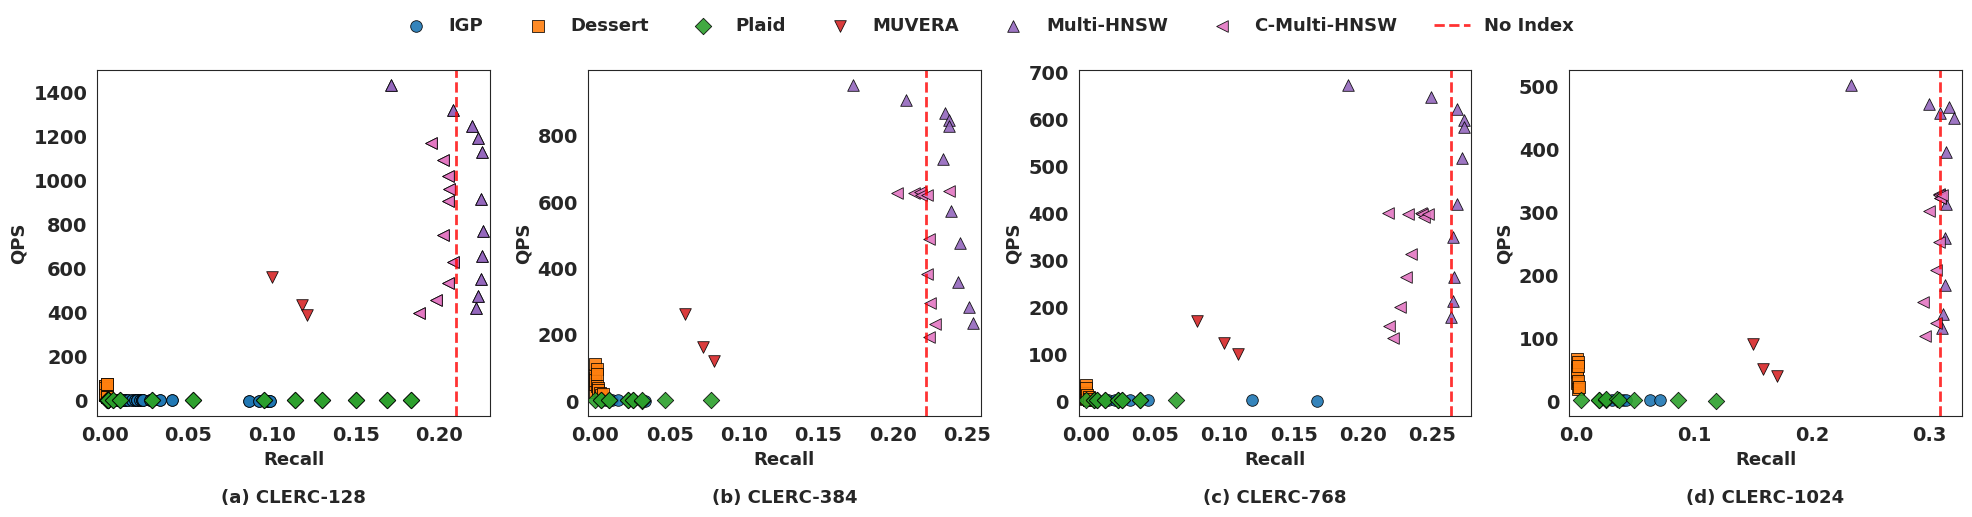

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps as cm
import string

# -----------------------------
# 1. Global Plot Configuration
# -----------------------------
sns.set_style("white")  # no gridlines

plt.rcParams.update({
    'font.size': 16,
    'font.weight': 'bold',
    'axes.labelweight': 'bold',
    'axes.titlesize': 16,
    'axes.titleweight': 'bold'
})

# -----------------------------
# 2. Algorithm Style Map
# -----------------------------
markers = ['o', 's', 'D', 'v', '^', '>', '<', 'p', '*', 'h', 'H', '+', 'x']
cmap = cm.get_cmap('tab10')
color_list = list(getattr(cmap, 'colors', [cmap(i / 10.0) for i in range(10)]))

algorithm_map = {
    algo: {
        'marker': markers[i % len(markers)],
        'color': color_list[i % len(color_list)]
    }
    for i, algo in enumerate(algorithms)
}

# -----------------------------
# 3. Dataset Label Map (Paper Consistency)
# -----------------------------
subplot_labels = {
    'sift1m': 'SIFT1M',
    'gist1m': 'GIST1M',
    'deep1m': 'DEEP1M',
    'glove1m': 'GloVe1M',
    'msong': 'MSong',
    'tiny5m': 'Tiny5M'
}

# -----------------------------
# 4. Create Figure Layout (1 Row)
# -----------------------------
n_datasets = len(datasets)
fig, axes = plt.subplots(nrows=1, ncols=n_datasets, figsize=(5 * n_datasets, 5))
axes = axes.flatten() if n_datasets > 1 else [axes]

# Compute QPS if missing
if 'QPS' not in df.columns and 'Time (msec)' in df.columns:
    df['QPS'] = 1000.0 / df['Time (msec)']

# -----------------------------
# 5. Plot Each Dataset
# -----------------------------
MVR_wo = [0.21, 0.222, 0.264, 0.309]  # red line x-values

for i, ds in enumerate(datasets):
    ax = axes[i]
    df_subset = df[df['Dataset'] == ds]

    for algo in algorithms:
        if algo == 'MVR-HNSW':
            continue
        data = df_subset[df_subset['Algorithm'] == algo].copy()
        data = data.sort_values(by='Recall')
        style = algorithm_map[algo]

        ax.scatter(
            data['Recall'],
            data['QPS'],
            label=algo,
            color=style['color'],
            marker=style['marker'],
            s=70,
            edgecolor='black',
            linewidth=0.6,
            alpha=0.9
        )

    # Axis scaling
    if not df_subset.empty:
        recall_min, recall_max = df_subset['Recall'].min(), df_subset['Recall'].max()
        qps_min, qps_max = df_subset['QPS'].min(), df_subset['QPS'].max()

        x_margin = 0.02 * (recall_max - recall_min if recall_max > recall_min else 0.1)
        y_margin = 0.05 * (qps_max - qps_min if qps_max > qps_min else 1)

        # Ensure the MVR_wo line fits within the plot
        if i < len(MVR_wo):
            recall_max = max(recall_max, MVR_wo[i] + x_margin)

        ax.set_xlim(recall_min - x_margin, recall_max + x_margin)
        ax.set_ylim(qps_min - y_margin, qps_max + y_margin)

    ax.set_xlabel('Recall', fontsize=13, fontweight='bold')
    ax.set_ylabel('QPS', fontsize=13, fontweight='bold')
    ax.tick_params(axis='both', labelsize=14, width=1.8)

    subplot_letter = f"({string.ascii_lowercase[i]}) "
    ax.text(
        0.5, -0.25,
        subplot_letter + subplot_labels.get(ds, ds),
        transform=ax.transAxes,
        ha='center',
        fontsize=13,
        fontweight='bold'
    )

# -----------------------------
# 5.1 Add Dotted Red Line (MVR_wo)
# -----------------------------
for i, ax in enumerate(axes):
    if i < len(MVR_wo):
        ax.axvline(
            x=MVR_wo[i],
            color='red',
            linestyle='--',
            linewidth=2,
            alpha=0.8,
            label='No Index' if i == 0 else None  # add label only once
        )

# -----------------------------
# 6. Legend (Top Center)
# -----------------------------
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.08),
    ncol=len(algorithms) + 1,  # +1 for MVR_wo line
    fontsize=13,
    frameon=False
)

# -----------------------------
# 7. Cleanup & Save
# -----------------------------
plt.tight_layout(rect=[0, 0, 1, 1])
fig.savefig('query_performance_plot_single_row_with_MVRwo.png', dpi=300, bbox_inches='tight')
plt.show()
